<img src="http://vision.skills.network/logo-light.png" width="400" alt="CV Studio logo"  />


<h2>Object Detection with Convolution Neural Network (CNN) based on Tensorflow</h2>
<h3>Application: Mask Detection</h3>


Estimated time needed: **30** minutes


## Objectives 


You will learn how to train a deep neural network for object detection in images using <a href="https://cs231n.github.io/transfer-learning/">transfer learning</a> with <a href="https://www.tensorflow.org/lite/examples/object_detection/overview">a Mobilenet model</a>.

You will detect whether a person is wearing a mask or not. All you need to do is to annotate the provided image dataset and train the model using IBM CV Studio. In practice, very few people train an entire Convolutional Network from scratch (with random initialization) because it needs high computational power such as GPU and TPU and it is relatively rare to have a dataset of sufficient size. Instead, it is common to train a Convolutional Network on a very large dataset in the lab, then use this network to train your model. That is what we will do in this lab.


## Import Libraries and Define Auxiliary Functions



Import libraries for OS and Cloud:


In [1]:
%%capture
!pip install --no-deps lvis
!pip install tf_slim
!pip install --no-deps tensorflowjs==1.4.0
!pip install tensorflow==1.15.2
!pip install tensorflow_hub

from IPython.display import display, Javascript, Image
import re
import zipfile
from base64 import b64decode
import sys
import os
import json

import io
import random

import tarfile
from datetime import datetime
from zipfile import ZipFile
import six.moves.urllib as urllib
import PIL.Image
from PIL import Image

Import libraries for Tensorflow:


In [2]:
%%capture
import tensorflow as tf
from object_detection.utils import dataset_util, label_map_util, config_util
from object_detection.utils.label_map_util import get_label_map_dict
from skillsnetwork import cvstudio

Download the files needed to build the model:


In [3]:
%%capture
import os
if os.path.exists("content-latest.zip"):
    pass
else:
    !wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/CV0101/content/data/content-latest.zip
    !wget https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/CV0101/content/data/tfrecord.py
    
with zipfile.ZipFile('content-latest.zip', 'r') as zip_ref:
    zip_ref.extractall('')

Set up CV Studio Client and download the images:


In [4]:
# Initialize the CV Studio Client
cvstudioClient = cvstudio.CVStudio()

# Download All Images
cvstudioClient.downloadAll()

100%|██████████| 100/100 [00:38<00:00,  2.62it/s]


In [5]:
# Get the annotations from CV Studio
annotations = cvstudioClient.get_annotations()
labels = annotations['labels']

Set up the folders paths to the output:


In [6]:
CHECKPOINT_PATH = os.path.join(os.getcwd(),'content/checkpoint')
OUTPUT_PATH = os.path.join(os.getcwd(),'content/output')
EXPORTED_PATH = os.path.join(os.getcwd(),'content/exported')
DATA_PATH = os.path.join(os.getcwd(),'content/data')
CONFIG_PATH = os.path.join(os.getcwd(),'content/config')
LABEL_MAP_PATH = os.path.join(DATA_PATH, 'label_map.pbtxt')
TRAIN_RECORD_PATH = os.path.join(DATA_PATH, 'train.record')
VAL_RECORD_PATH = os.path.join(DATA_PATH, 'val.record')

## Image Pre-Processing 


Give an <code>id</code> number for each annotated image as a label map starting from 1:


In [7]:
os.makedirs(DATA_PATH, exist_ok=True)
with open(LABEL_MAP_PATH, 'w') as f:
    for idx, label in enumerate(labels):
        f.write('item {\n')
        f.write("\tname: '{}'\n".format(label))
        f.write('\tid: {}\n'.format(idx + 1))
        f.write('}\n')

Generating TFRecord is Tensorflow’s binary storage format. Using a binary file format for storage of your data can have a significant impact on the performance of your import pipeline  as a consequence on the training time of your model. Go to this link https://www.tensorflow.org/tutorials/load_data/tfrecord to learn more about it. 

Then, the images will be split as 70% for the training dataset <code>train_examples</code> and 30% for validation dataset <code>val_examples</code>.


In [8]:
from tfrecord1 import create_tf_record, displaydetectedobject
image_files = [image for image in annotations["annotations"].keys()]

label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)

random.seed(42)
random.shuffle(image_files)
num_train = int(0.7 * len(image_files))
train_examples = image_files[:num_train]
val_examples = image_files[num_train:]

create_tf_record(train_examples, annotations["annotations"], label_map, os.path.join(os.getcwd(),'images'), TRAIN_RECORD_PATH)
create_tf_record(val_examples, annotations["annotations"], label_map, os.path.join(os.getcwd(),'images'), VAL_RECORD_PATH)

## Selecting the Model 

You will upload your object detection model configuration which is MobileNet V1 from tensorflow.org. There are also many other object detection models available. If you are interested go to this link (https://github.com/tensorflow/models/blob/7c2ff1afc4423266223bcd50cba0ed55aca826c8/research/object_detection/g3doc/tf1_detection_zoo.md) and you will find many other models. Training a model from scratch can take long hours and tons of data. So, we helped you in reducing that effort by training the MobileNet model with a checkpoint.

The model that will be trained is the SSD MobileNet architecture. SSD MobileNet models have very small file sizes and can execute very quickly, compromising little accuracy, which makes it perfect for running in the browser.


In [9]:
MODEL_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
CONFIG_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync'
download_base = 'http://download.tensorflow.org/models/object_detection/'
model = MODEL_TYPE + '.tar.gz'
tmp = '/resources/checkpoint.tar.gz'

if not (os.path.exists(CHECKPOINT_PATH)):
    # Download the checkpoint
    opener = urllib.request.URLopener()
    opener.retrieve(download_base + model, tmp)

    # Extract all the `model.ckpt` files.
    with tarfile.open(tmp) as tar:
        for member in tar.getmembers():
            member.name = os.path.basename(member.name)
            if 'model.ckpt' in member.name:
                tar.extract(member, path=CHECKPOINT_PATH)
            if 'pipeline.config' in member.name:
                tar.extract(member, path=CONFIG_PATH)

    os.remove(tmp)

## Building the Model Training Pipeline  


This is the the last stage before we start training the model. We need to inject our pipeline with the label map and TFRecord that we created previosuly in this notebook. As mentioned earlier, you won't start training the model from scratch, so we will use a model checkpoint. We set the batch size to be 6. This notebook won't have the sufficient memory power to handle a batch size higher than 6.


In [10]:
pipeline_skeleton = 'content/models/research/object_detection/samples/configs/' + CONFIG_TYPE + '.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_skeleton)

label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)
num_classes = len(label_map.keys())
meta_arch = configs["model"].WhichOneof("model")

override_dict = {
  'model.{}.num_classes'.format(meta_arch): num_classes,
  'train_config.batch_size': 6,
  'train_input_path': TRAIN_RECORD_PATH,
  'eval_input_path': VAL_RECORD_PATH,
  'train_config.fine_tune_checkpoint': os.path.join(CHECKPOINT_PATH, 'model.ckpt'),
  'label_map_path': LABEL_MAP_PATH
}

configs = config_util.merge_external_params_with_configs(configs, kwargs_dict=override_dict)
pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_config, DATA_PATH)

## Start Training
We will start the training run by calling the `model_main` script. Then, we will be passing the configuration shown in the above cell as `pipepline.config`.


In order to build the model, we have to set different <code>PATH</code> to train MobileNet.


In [11]:
paths = [
    f'home/jupyterlab/conda/envs/python/lib/python3.6',
    f'content/models/research',
    f'content/models/research/slim'
]
os.environ['PYTHONPATH'] = ':'.join(paths)

The first step is to set <code>epochs</code> as 40. That will take between 3 to 7 minutes to complete the training. One epoch is when an ENTIRE dataset is passed forward and backward through the neural network only once.


In [12]:
%%capture
epochs = 40
start_datetime = datetime.now()
!python -m object_detection.model_main \
    --pipeline_config_path=$DATA_PATH/pipeline.config \
    --num_train_steps=$epochs \
    --num_eval_steps=100

regex = re.compile(r"model\.ckpt-([0-9]+)\.index")
numbers = [int(regex.search(f).group(1)) for f in os.listdir(OUTPUT_PATH) if regex.search(f)]
TRAINED_CHECKPOINT_PREFIX = os.path.join(OUTPUT_PATH, 'model.ckpt-{}'.format(max(numbers)))

!python3 -m object_detection.export_inference_graph \
  --pipeline_config_path=$DATA_PATH/pipeline.config \
  --trained_checkpoint_prefix=$TRAINED_CHECKPOINT_PREFIX \
  --output_directory=$EXPORTED_PATH
end_datetime = datetime.now()

## Let's Test the Model and See How Cool It Is!


We are going to use the image saved in this notebook. You can also add your own image by providing a URL.


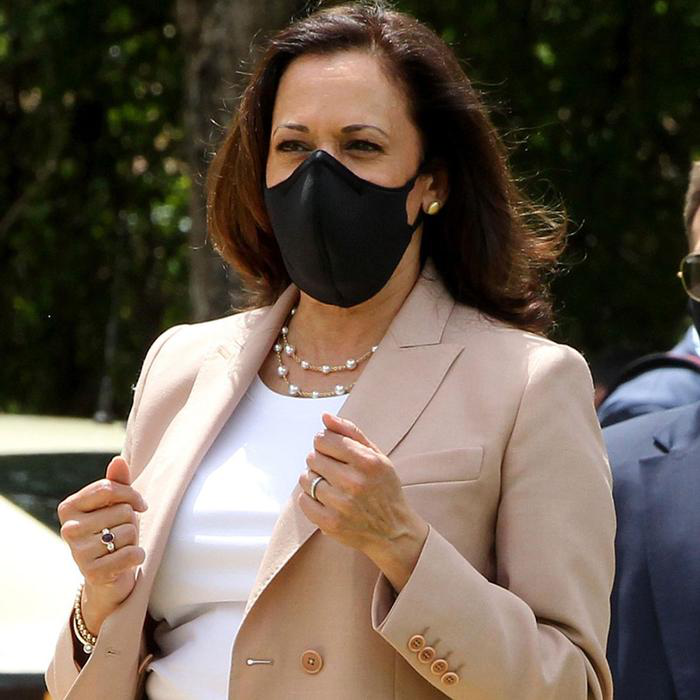

In [13]:
from PIL import Image

# Here you can specify your own image 
URL = 'https://cdn.cliqueinc.com/posts/289533/kamala-harris-face-mask-289533-1602269219518-square.700x0c.jpg' 

with urllib.request.urlopen(URL) as url:
    with open('test.jpg', 'wb') as f:
        f.write(url.read())
image = Image.open('test.jpg')

image

2023-11-16 01:04:45.215417: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-11-16 01:04:45.229692: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2394290000 Hz
2023-11-16 01:04:45.230498: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56033915fd20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-16 01:04:45.230558: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Wears mask 


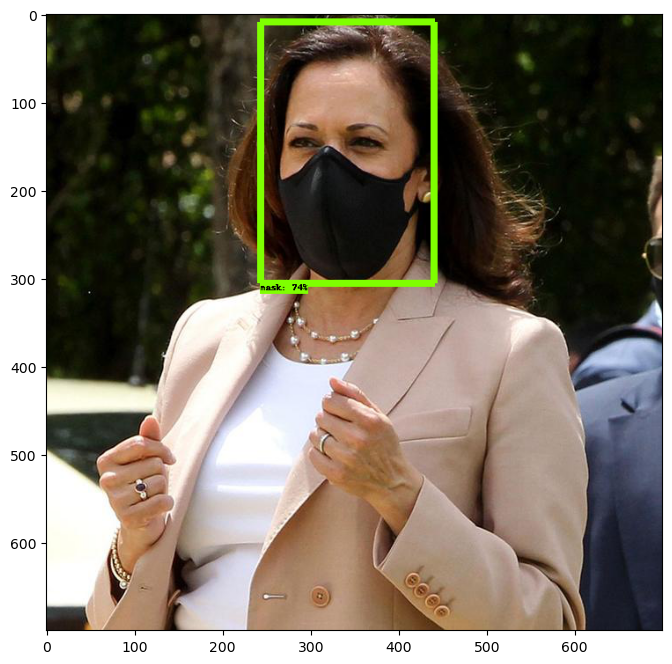

In [14]:
%matplotlib inline
import numpy as np
n,img,accuracy=displaydetectedobject(image)

## Let's Report the Results


In [15]:
parameters = {
    'epochs': epochs
}

result = cvstudioClient.report(started=start_datetime, completed=end_datetime, parameters=parameters, accuracy= round(float(accuracy),2)*100)

if result.ok:
    print('Congratulations your results have been reported back to CV Studio!')

Congratulations your results have been reported back to CV Studio!


## Save the Model for Deployment


In [16]:
%%capture
!tensorflowjs_converter \
  --input_format=tf_frozen_model \
  --output_format=tfjs_graph_model \
  --output_node_names='Postprocessor/ExpandDims_1,Postprocessor/Slice' \
  --quantization_bytes=1 \
  --skip_op_check \
  $EXPORTED_PATH/frozen_inference_graph.pb \
  .
import json

from object_detection.utils.label_map_util import get_label_map_dict

label_map = get_label_map_dict(LABEL_MAP_PATH)
label_array = [k for k in sorted(label_map, key=label_map.get)]

with open(os.path.join('', 'labels.json'), 'w') as f:
    json.dump(label_array, f)


In [17]:
#!cd model_web 
with ZipFile('model_web.zip','w') as zip:
    zip.write('group1-shard1of2.bin')
    zip.write('group1-shard2of2.bin')
    zip.write('model.json')
    zip.write('labels.json')
    

In [18]:
# Download All Images
cvstudioClient.uploadModel('model_web.zip', {'epochs': epochs })

File Uploaded


<img src="https://i.pinimg.com/originals/48/6b/bc/486bbc7b49a92e11070bca0e719f14e9.gif" alt="W3Schools.com">


## What's Next


You can also deploy your model via Web Application or Web App. This allows users to interact with your model like a website. They can upload the image with a user interface and view the results. Let's see how we can deploy a web app in CV Studio. 

In CV Studio, go to the **Use Model** section and select **New Application**. Fill out the window as follows: give your model a name, select **Models in this project**, select **TEST-1-click Deploy your Model to Cloud (Code Engine)** and select the model from the training run as shown here:

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_8.19_AM.jpeg"  alt="popup" width="400" height="500">
</p>


Once the window is filled out, press the **Create Application** button and your model will begin deploying.
<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/C2FE713D-E007-40E6-9E8A-CDFF9C3EF8DA_4_5005_c.jpeg"  alt="popup" width="500" height="100">
</p>

Wait until the status changes from "DEPLOYING" to "READY". Once the status changes to "READY", your application is ready for you to use!

<p>
<img  src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-SkillsNetwork/images/Image_2021-05-20_at_8.20_AM__1_.jpeg"  alt="popup" width="500" height="100">
</p>

You can press now press the URL to go to your web application!


## Authors 


Nayef Abou Tayoun is a Cognitive Data Scientist in the Skill Network Group at IBM. Currently, Nayef is pursuing the Master of Management in Artificial Intelligence degree at Queen's University in Canada. Nayef focuses on Machine Learning, Deep Learning, and Computer Vision.


|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2021-05-25  | 0.3  | Kathy  |  Modified Multiple Areas |
| 2021-05-25  | 0.3  | Yasmine  |  Modified Multiple Areas |
| 2020-07-20  | 0.2  | Azim  |  Modified Multiple Areas |
| 2020-07-17  | 0.1  | Azim  |  Created Lab Template |


Copyright © 2021 IBM Corporation. All rights reserved.
